In [1]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers

print(tf.__version__)

#%pip install git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

from  IPython import display
from matplotlib import pyplot as plt

import numpy as np

import pathlib
import shutil
import tempfile
import GPUtil
import psutil
import time

2.17.0


In [2]:
import tensorflow as tf

FEATURES = 28
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')
ds = tf.data.experimental.CsvDataset(gz, [tf.float32]*(FEATURES+1), compression_type="GZIP")

# Shuffle the dataset
BUFFER_SIZE = int(1e4)
ds = ds.shuffle(buffer_size=BUFFER_SIZE, reshuffle_each_iteration=True)

# Split features and labels
ds = ds.map(lambda *x: (tf.stack(x[1:]), x[0]))

# Calculate the size of the dataset
# Defining parameters for NN
N_VALIDATION = int(1e4)
N_TRAIN = int(1e5)
BUFFER_SIZE = int(1e5)
#BATCH_SIZE = 500
dataset_size = BUFFER_SIZE

# Split into training and test datasets (80-20 split)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size

ds_train = ds.take(train_size)
ds_val = ds.skip(train_size)

# Batch the datasets
BATCH_SIZE = 1024
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE
ds_train = ds_train.batch(BATCH_SIZE)
ds_val = ds_val.batch(BATCH_SIZE)

# Normalize the features within the dataset
def normalize(x, y):
    x = tf.cast(x, tf.float32)
    x = x / 255.0  # Adjust this based on your specific data range
    return x, y

ds_train = ds_train.map(normalize)
ds_val = ds_val.map(normalize)

# One-hot encode the labels
def one_hot_encode(x, y):
    y = tf.one_hot(tf.cast(y, tf.int32), depth=2)  # 2 classes: 0 and 1
    return x, y

ds_train = ds_train.map(one_hot_encode)
ds_val = ds_val.map(one_hot_encode)

# Prefetch to improve performance
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)
ds_val = ds_val.prefetch(tf.data.experimental.AUTOTUNE)

print(ds_train)
print(ds_val)

# Convert to tensors
X_train, y_train = next(iter(ds_train))
X_val, y_val = next(iter(ds_val))

# Now X_train, y_train, X_val, and y_val are ready for use
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 28), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 28), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>
X_train shape: (1024, 28), y_train shape: (1024, 2)
X_val shape: (1024, 28), y_val shape: (1024, 2)


In [3]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

In [4]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

def get_callbacks(name):
  return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
    tf.keras.callbacks.TensorBoard(logdir/name),
  ]

# TensorBoards have been shutdown since 1. January 2024

def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
  if optimizer is None:
    optimizer = get_optimizer()
  model.compile(optimizer=optimizer,
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[
                  tf.keras.metrics.BinaryCrossentropy(
                      from_logits=True, name='binary_crossentropy'),
                  'accuracy'])

  model.summary()

  history = model.fit(
    X_train,
    y_train,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs=max_epochs,
    validation_data=(X_val, y_val),
    callbacks=get_callbacks(name),
    verbose=0)
  return history

In [5]:
size_histories = {}

In [6]:
tiny_model = tf.keras.Sequential([
    layers.Dense(16, activation='elu', input_shape=(FEATURES, )),
    layers.Dense(2, activation='softmax')
    #layers.Dense(16, activation='elu', input_shape=(FEATURES, 1)),
    #layers.Dense(1, input_shape=(FEATURES, 1))

    #tf.keras.layers.Flatten()
])

small_model = tf.keras.Sequential([
    # `input_shape` is only required here so that `.summary` works.
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(16, activation='elu'),
    layers.Dense(2, activation='softmax')
])

medium_model = tf.keras.Sequential([
    layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(64, activation='elu'),
    layers.Dense(64, activation='elu'),
    layers.Dense(2, activation='softmax')
])

large_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(2, activation='softmax')
])

c:\Programming\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny')
size_histories['Small'] = compile_and_fit(small_model, 'sizes/Small')
size_histories['Medium']  = compile_and_fit(medium_model, "sizes/Medium")
size_histories['Large'] = compile_and_fit(large_model, "sizes/Large")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │           464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 498 (1.95 KB)

 Trainable params: 498 (1.95 KB)

 Non-trainable params: 0 (0.00 B)

c:\Programming\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\nn.py:681: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(



Epoch: 0, accuracy:0.5312,  binary_crossentropy:0.6924,  loss:0.6924,  val_accuracy:0.5205,  val_binary_crossentropy:0.6924,  val_loss:0.6924,  
.

c:\Programming\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


...................................................................................................
Epoch: 100, accuracy:0.5918,  binary_crossentropy:0.6683,  loss:0.6683,  val_accuracy:0.5410,  val_binary_crossentropy:0.6821,  val_loss:0.6821,  
....................................................................................................
Epoch: 200, accuracy:0.6299,  binary_crossentropy:0.6426,  loss:0.6426,  val_accuracy:0.5781,  val_binary_crossentropy:0.6729,  val_loss:0.6729,  
....................................................................................................
Epoch: 300, accuracy:0.6230,  binary_crossentropy:0.6355,  loss:0.6355,  val_accuracy:0.5850,  val_binary_crossentropy:0.6710,  val_loss:0.6710,  
....................................................................................................
Epoch: 400, accuracy:0.6416,  binary_crossentropy:0.6309,  loss:0.6309,  val_accuracy:0.5879,  val_binary_crossentropy:0.6711,  val_loss:0.6711,  
.........

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 16)             │           464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 770 (3.01 KB)

 Trainable params: 770 (3.01 KB)

 Non-trainable params: 0 (0.00 B)


Epoch: 0, accuracy:0.5283,  binary_crossentropy:0.6925,  loss:0.6925,  val_accuracy:0.5205,  val_binary_crossentropy:0.6923,  val_loss:0.6923,  
....................................................................................................
Epoch: 100, accuracy:0.6318,  binary_crossentropy:0.6374,  loss:0.6374,  val_accuracy:0.5850,  val_binary_crossentropy:0.6835,  val_loss:0.6835,  
....................................................................................................
Epoch: 200, accuracy:0.6260,  binary_crossentropy:0.6319,  loss:0.6319,  val_accuracy:0.5752,  val_binary_crossentropy:0.6914,  val_loss:0.6914,  
....................................................................................................
Epoch: 300, accuracy:0.6309,  binary_crossentropy:0.6301,  loss:0.6301,  val_accuracy:0.5811,  val_binary_crossentropy:0.6941,  val_loss:0.6941,  
....................................................................................................
Epoch: 40

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 64)             │         1,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,306 (40.26 KB)

 Trainable params: 10,306 (40.26 KB)

 Non-trainable params: 0 (0.00 B)


Epoch: 0, accuracy:0.5156,  binary_crossentropy:0.6928,  loss:0.6928,  val_accuracy:0.5205,  val_binary_crossentropy:0.6924,  val_loss:0.6924,  
....................................................................................................
Epoch: 100, accuracy:0.6377,  binary_crossentropy:0.6332,  loss:0.6332,  val_accuracy:0.5928,  val_binary_crossentropy:0.6765,  val_loss:0.6765,  
....................................................................................................
Epoch: 200, accuracy:0.6416,  binary_crossentropy:0.6122,  loss:0.6122,  val_accuracy:0.5918,  val_binary_crossentropy:0.6754,  val_loss:0.6754,  
....................................................................................................
Epoch: 300, accuracy:0.6777,  binary_crossentropy:0.5979,  loss:0.5979,  val_accuracy:0.6201,  val_binary_crossentropy:0.6655,  val_loss:0.6655,  
....................................................................................................
Epoch: 40

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 512)            │        14,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 803,842 (3.07 MB)

 Trainable params: 803,842 (3.07 MB)

 Non-trainable params: 0 (0.00 B)


Epoch: 0, accuracy:0.5215,  binary_crossentropy:0.6933,  loss:0.6933,  val_accuracy:0.5205,  val_binary_crossentropy:0.6923,  val_loss:0.6923,  
....................................................................................................
Epoch: 100, accuracy:0.6475,  binary_crossentropy:0.6321,  loss:0.6321,  val_accuracy:0.5889,  val_binary_crossentropy:0.6871,  val_loss:0.6871,  
....................................................................................................
Epoch: 200, accuracy:0.6445,  binary_crossentropy:0.6243,  loss:0.6243,  val_accuracy:0.6084,  val_binary_crossentropy:0.6804,  val_loss:0.6804,  
....................................................................................................
Epoch: 300, accuracy:0.6816,  binary_crossentropy:0.5829,  loss:0.5829,  val_accuracy:0.6152,  val_binary_crossentropy:0.6905,  val_loss:0.6905,  
....................................................................................................
Epoch: 40

Text(0.5, 0, 'Epochs [Log Scale]')

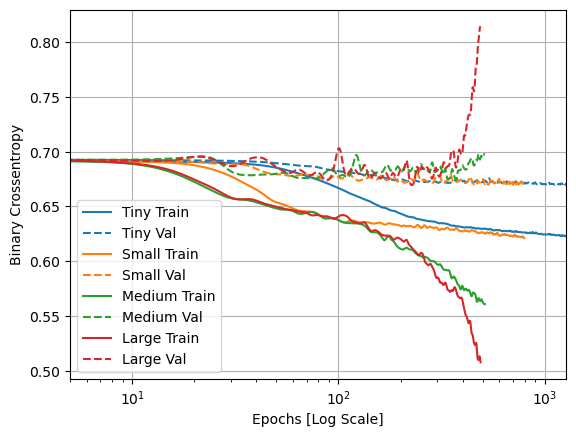

In [8]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)

plotter.plot(size_histories)

a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
#plt.ylim([0.5, 0.7])
plt.xlabel("Epochs [Log Scale]")

In [23]:
import matplotlib.pyplot as plt
import tensorflow_docs as tfdocs

def plot_loss(size_histories):
    plt.figure(figsize=(10, 6))
    
    #for name, history in size_histories.items():
    #    plt.plot(history.history['loss'], label=f'{name} Loss')

    plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)

    plotter.plot(size_histories)

    plt.xlim([5, max(plt.xlim())])
    plt.ylim([0.5, 0.9])
    
    plt.xscale('log')
    plt.xlabel("Epochs [Log Scale]")
    plt.ylabel("Loss")
    plt.legend()
    plt.title('Loss over Epochs')
    plt.show()

def plot_accuracy(size_histories):
    plt.figure(figsize=(10, 6))
    
    for name, history in size_histories.items():
        plt.plot(history.history['accuracy'], label=f'{name} Accuracy')
    
    plt.xscale('log')
    plt.xlabel("Epochs [Log Scale]")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title('Accuracy over Epochs')
    plt.show()


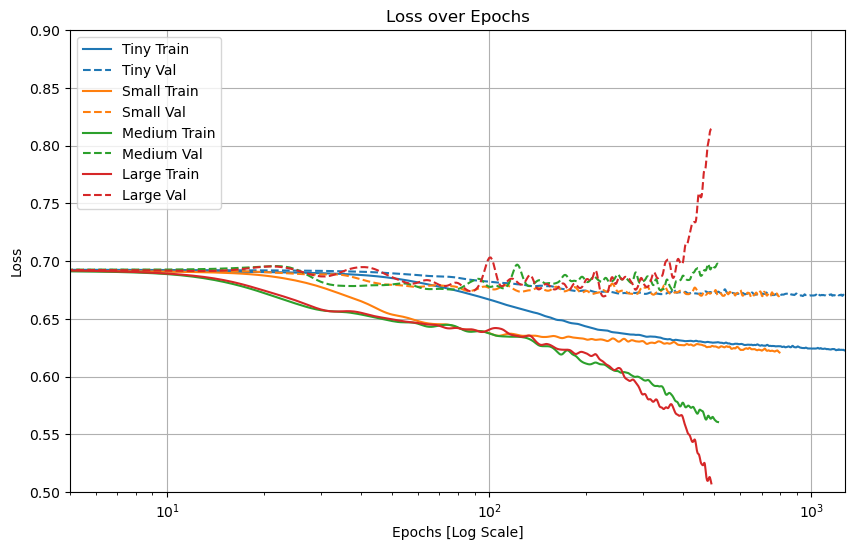

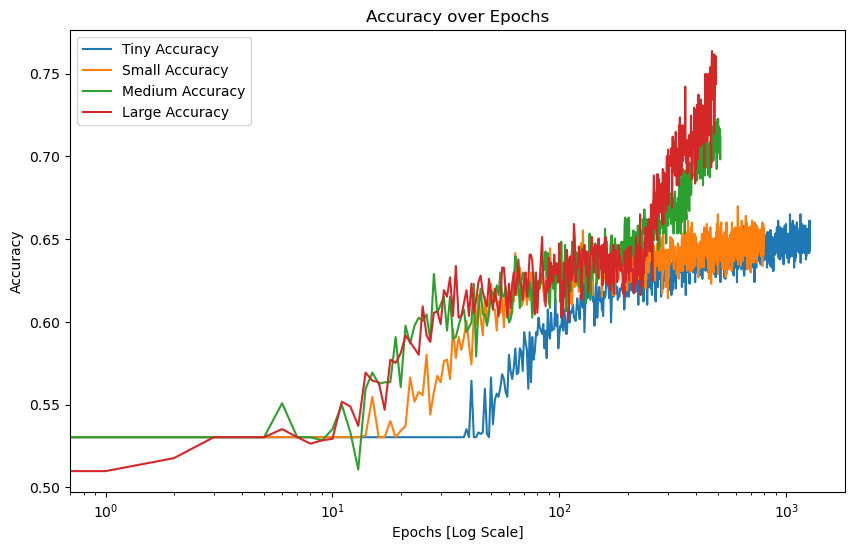

In [24]:
plot_loss(size_histories)
plot_accuracy(size_histories)

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix
import numpy as np
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import pathlib
import tempfile
import shutil

def plot_accuracy(size_histories, step):
    """
    Plots training and validation accuracy over epochs for multiple models.
    
    Args:
        size_histories (dict): Dictionary where keys are model names and values are TensorFlow History objects.
    """
    plt.figure(figsize=(12, 8))

    # Generate a color palette based on the number of models
    num_models = len(size_histories)
    colors = sns.color_palette("hsv", num_models)  # Using a seaborn color palette

    for i, (name, history) in enumerate(size_histories.items()):
        epochs = history.epoch[::step]
        acc = history.history['accuracy'][::step]
        val_acc = history.history['val_accuracy'][::step]

        plt.plot(epochs, acc, color=colors[i], label=f'{name} Training Accuracy')
        plt.plot(epochs, val_acc, linestyle="--", color=colors[i], label=f'{name} Validation Accuracy')
    
    plt.xscale("log")
    #plt.yscale("log")
    #plt.xlim(0, max(plt.xlim()))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_roc_curves(models, validation_data, step):
    """
    Plots ROC curves for multiple models on the same figure.
    
    Args:
        models (dict): Dictionary where keys are model names and values are trained TensorFlow models.
        X_test (numpy.array): Test features.
        y_test (numpy.array): True binary labels for the test set.
    """
    plt.figure(figsize=(12, 8))
    
    for name, model in models.items():
        #y_pred_prob = model.predict(X_test).ravel()
        y_pred = model.predict(validation_data.map(lambda x, _: x))  # Get predictions
        y_true = np.concatenate([y for _, y in validation_data], axis=0)  # Get true labels

        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr[::step], tpr[::step], label=f'{name} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Different Models')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()



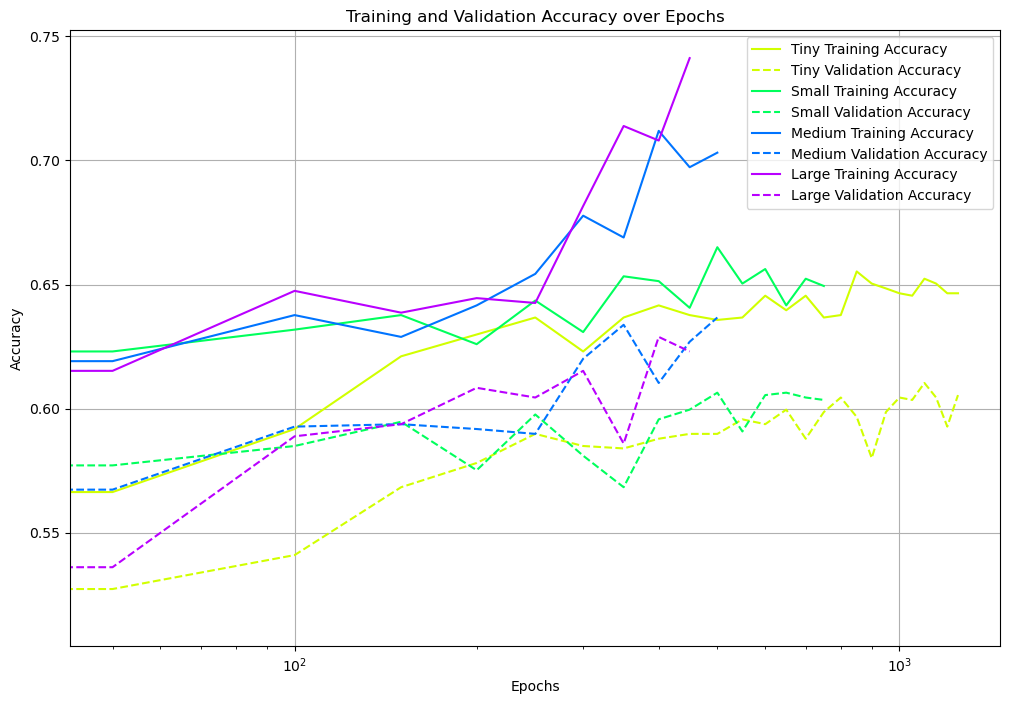

In [12]:
# Example usage:
# Assuming you have your models trained and histories saved
models = {
    'Tiny': tiny_model,
    'Small': small_model,
    'Medium': medium_model,
    'Large': large_model
    # Add other models as needed
}

# And size_histories containing their training histories
plot_accuracy(size_histories, 50)
#plot_roc_curves(models, ds_val, 100)

In [13]:
import matplotlib.pyplot as plt
import tensorflow_docs as tfdocs

def plot_loss(size_histories):
    plt.figure(figsize=(10, 6))
    
    #for name, history in size_histories.items():
    #    plt.plot(history.history['loss'], label=f'{name} Loss')

    plotter = tfdocs.plots.HistoryPlotter(metric='binary_crossentropy', smoothing_std=10)

    plotter.plot(size_histories)

    #plt.xlim([0, max(plt.xlim())])
    #plt.xlim(0, max(plt.xlim()))
    plt.xlim(0, 1000)
    #plt.ylim([0.5, 0.7])
    
    #plt.xscale('log')
    plt.xlabel("Epochs [Log Scale]")
    plt.ylabel("Loss")
    plt.legend()
    plt.title('Loss over Epochs')
    plt.show()

import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix


def plot_accuracy(size_histories, step):
    """
    Plots training and validation accuracy over epochs for multiple models.
    
    Args:
        size_histories (dict): Dictionary where keys are model names and values are TensorFlow History objects.
    """
    plt.figure(figsize=(12, 8))

    # Generate a color palette based on the number of models
    num_models = len(size_histories)
    colors = sns.color_palette("hsv", num_models)  # Using a seaborn color palette

    for i, (name, history) in enumerate(size_histories.items()):
        epochs = history.epoch[::step]
        acc = history.history['accuracy'][::step]
        val_acc = history.history['val_accuracy'][::step]

        plt.plot(epochs, acc, color=colors[i], label=f'{name} Training Accuracy')
        plt.plot(epochs, val_acc, linestyle="--", color=colors[i], label=f'{name} Validation Accuracy')
    
    #plt.xscale("log")
    #plt.yscale("log")
    #plt.xlim(0, max(plt.ylim()))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_roc_curves(models, X_validation, y_validation, step):
    """
    Plots ROC curves for multiple models on the same figure.
    
    Args:
        models (dict): Dictionary where keys are model names and values are trained TensorFlow models.
        X_test (numpy.array): Test features.
        y_test (numpy.array): True binary labels for the test set.
    """
    plt.figure(figsize=(12, 8))
    
    for name, model in models.items():
        #y_pred_prob = model.predict(X_test).ravel()
        y_pred = model.predict(X_validation)[:, 1]  # Get predictions
        #y_pred = tf.argmax(y_pred, axis=1)
        y_true = tf.argmax(y_validation, axis=1)

        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        roc_auc = auc(fpr, tpr)
        print(fpr)

        plt.plot(fpr[::step], tpr[::step], label=f'{name} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Different Models')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()



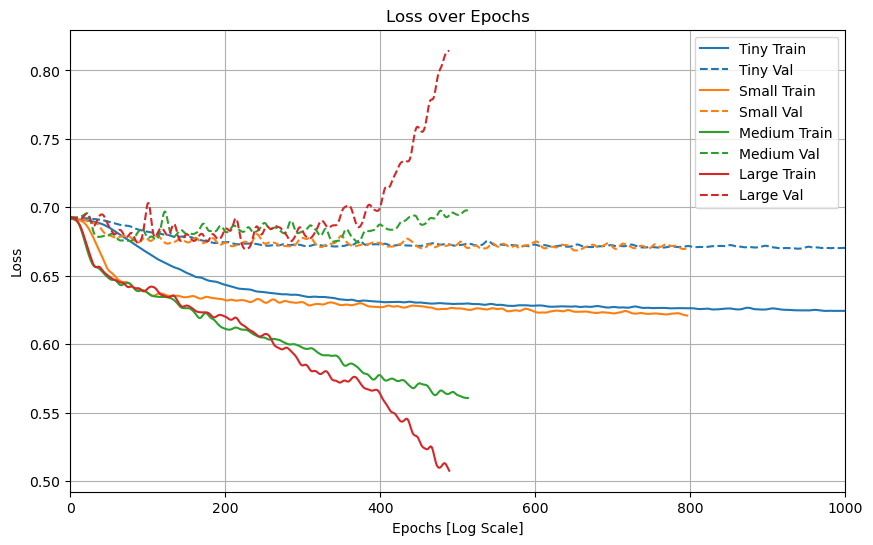

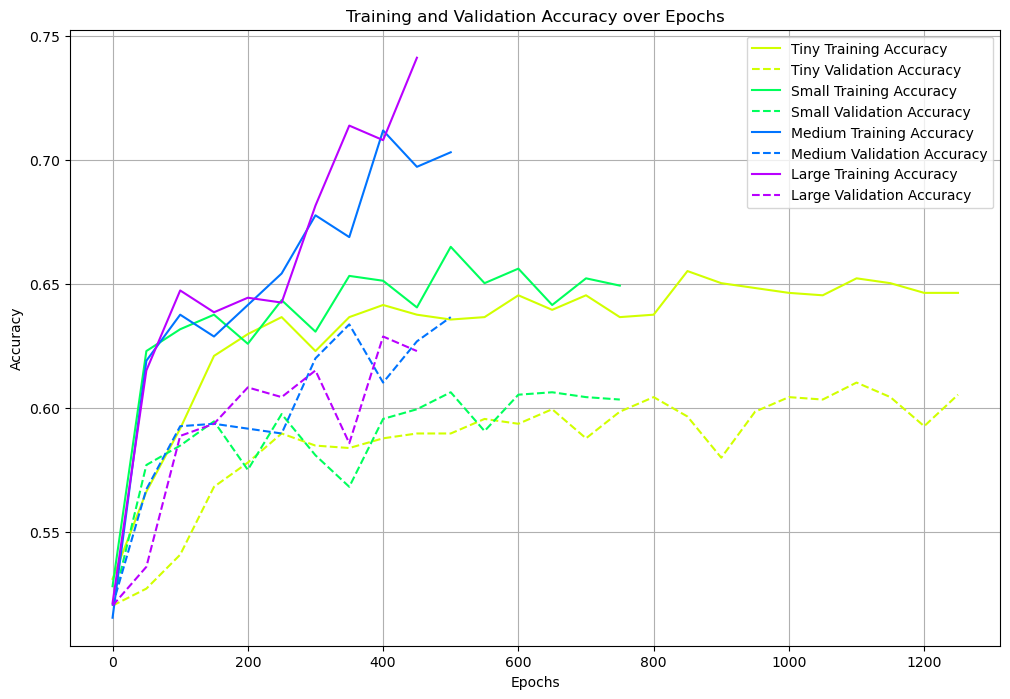

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step
[0.         0.         0.         0.00407332 0.00407332 0.00814664
 0.00814664 0.0101833  0.0101833  0.01221996 0.01221996 0.01425662
 0.01425662 0.01629328 0.01629328 0.01832994 0.01832994 0.0203666
 0.0203666  0.0305499  0.0305499  0.03258656 0.03258656 0.03462322
 0.03462322 0.03869654 0.03869654 0.0407332  0.0407332  0.04276986
 0.04276986 0.04480652 0.04480652 0.04684318 0.04684318 0.04887984
 0.04887984 0.0509165  0.0509165  0.05498982 0.05498982 0.06313646
 0.06313646 0.06720978 0.06720978 0.06924644 0.06924644 0.07331976
 0.07331976 0.07535642 0.07535642 0.07739308 0.07739308 0.0814664
 0.0814664  0.08350305 0.08350305 0.08757637 0.08757637 0.09775967
 0.09775967 0.09979633 0.09979633 0.10183299 0.10183299 0.10386965
 0.10386965 0.10590631 0.10590631 0.10794297 0.10794297 0.10997963
 0.10997963 0.11405295 0.11405295 0.11608961 0.11608961 0.12423625
 0.12423625 0.12627291 0.12627291 0.12830957 0.12830957 0.13034623
 0.13034623 0.13238289 

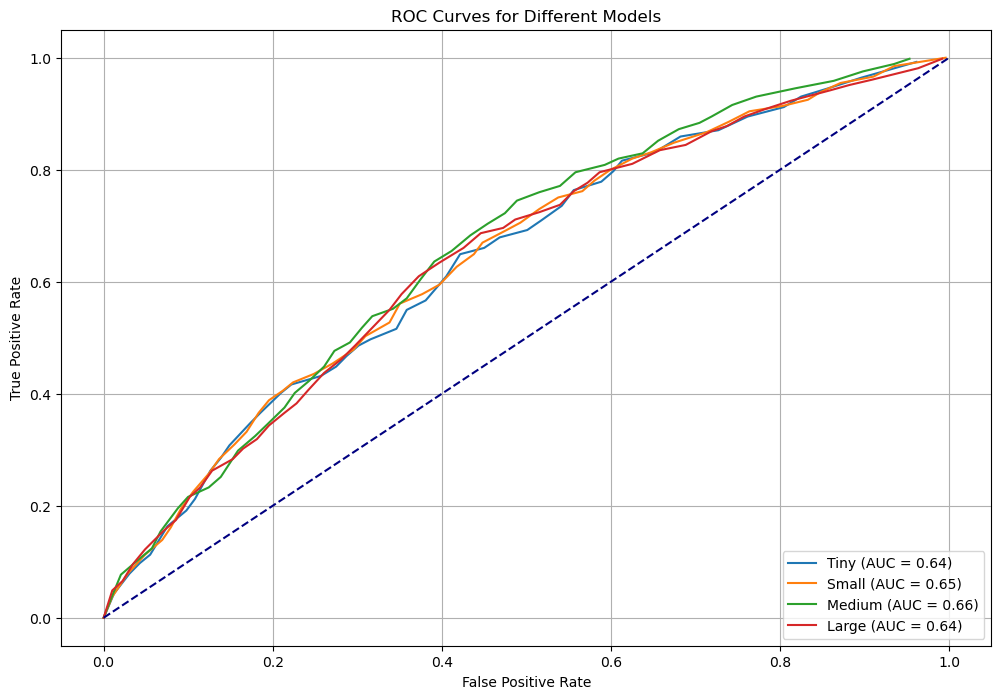

In [14]:
plot_loss(size_histories)
plot_accuracy(size_histories, 50)
plot_roc_curves(models, X_val, y_val, 10)

In [15]:
def plot_prediction_histogram(model_key_name, models, X_validation, y_validation):
    """
    Plots histograms of the model's predicted probabilities for each class label.
    
    Args:
        model (tf.keras.Model): The trained model.
        validation_data (tf.data.Dataset): The validation dataset.
    """
    #X_train_sig = X_validation[:, 1]
    #X_train_bac = X_validation[:, 0]
    #y_pred_sig = model.predict(X_train_sig)
    #y_pred_bac = model.predict(X_train_bac)
    model = models[model_key_name]
    y_pred = model.predict(X_validation)
    y_pred_sig = y_pred[:, 1]
    y_pred_bac = y_pred[:, 0]

    proba_class_1 = y_pred_sig
    proba_class_2 = y_pred_bac

    # Plot histograms
    plt.figure(figsize=(12, 6))
    
    # Histogram for class 1 probabilities
    plt.hist(proba_class_1, bins=50, density=True, histtype='step', color='blue', alpha=0.9, linewidth=3, label='Signal')
    plt.hist(proba_class_2, bins=50, density=True, histtype='step', color='orange', alpha=0.9, linewidth=3, label='Background')
    
    # Optional: Add a histogram for class 0 probabilities
    # Uncomment if you need to visualize the class 0 probabilities as well
    # proba_class_0 = y_pred_proba[:, 0]
    # plt.hist(proba_class_0, bins=30, color='blue', alpha=0.7, label='Class 0 Probability')
    
    # Adding titles and labels
    plt.xlabel('Probability')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of Model Predictions {model_key_name}')
    plt.legend()
    
    plt.grid(True)
    plt.show()

#plot_prediction_histogram(models['Relu'], X_val, y_val)

 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step


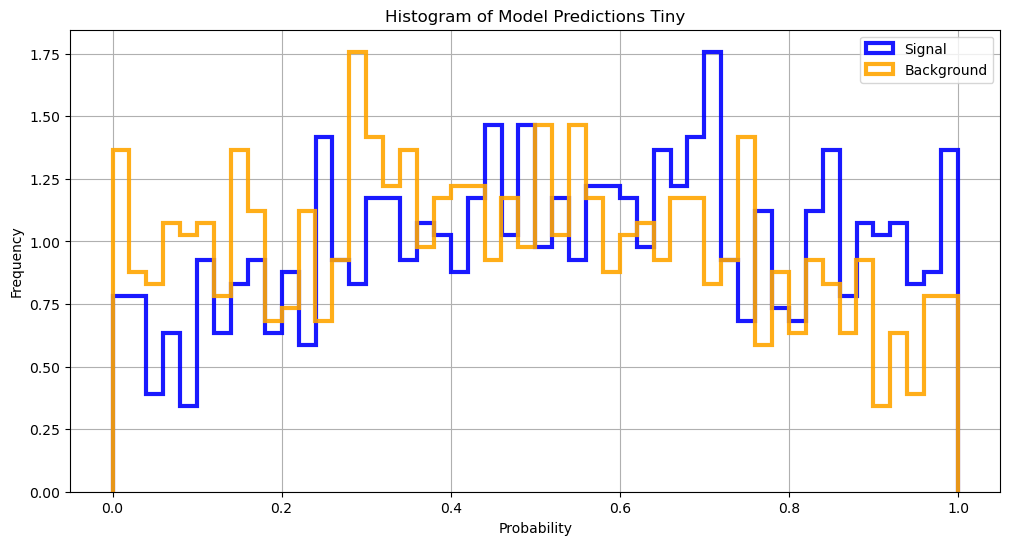

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step


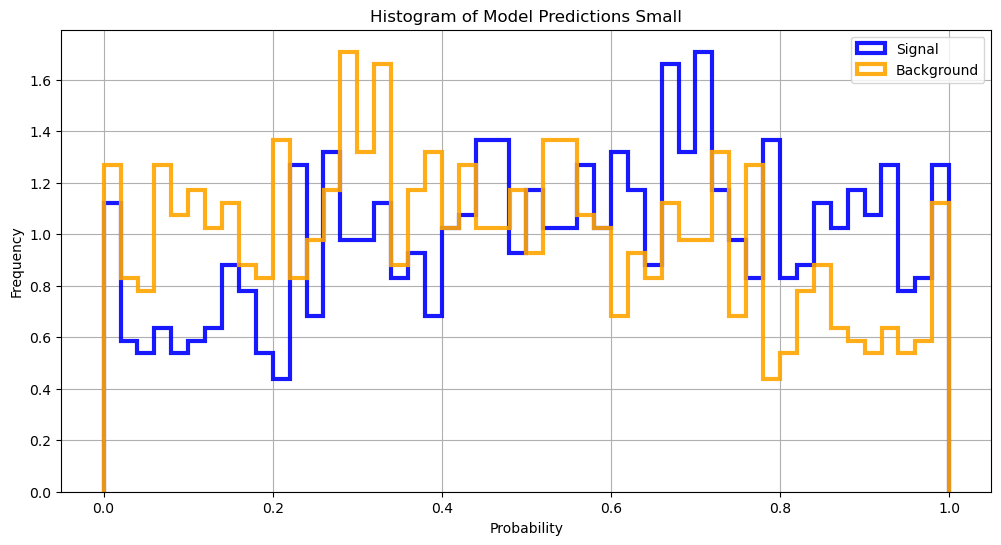

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step


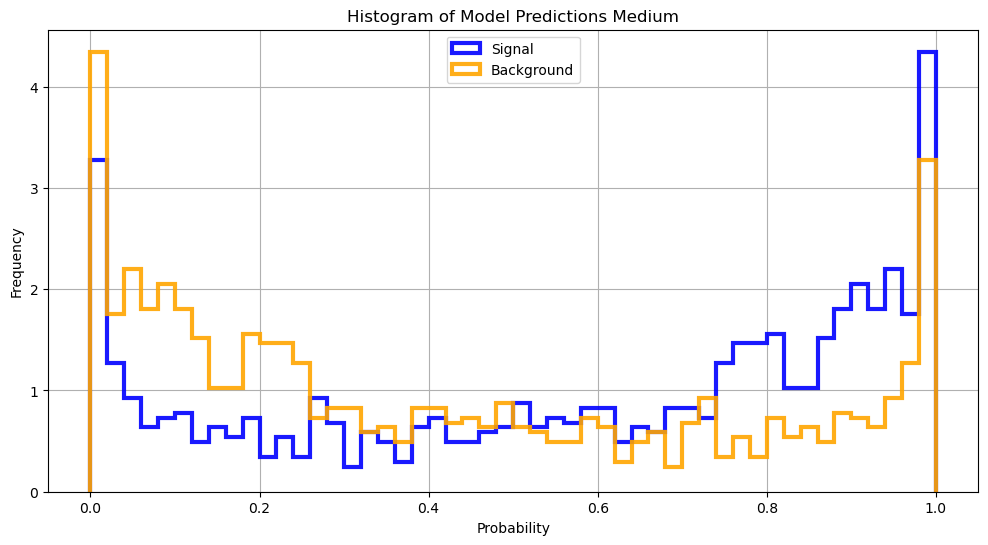

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


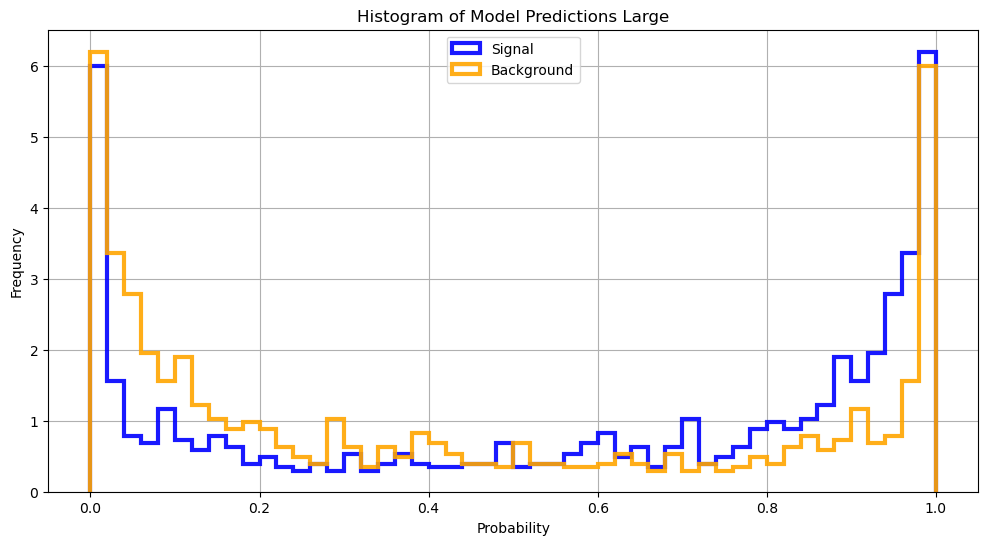

In [16]:
plot_prediction_histogram('Tiny', models, X_val, y_val)
plot_prediction_histogram('Small', models, X_val, y_val)
plot_prediction_histogram('Medium', models, X_val, y_val)
plot_prediction_histogram('Large', models, X_val, y_val)

In [17]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")


Num GPUs Available:  0
Please install GPU version of TF


In [18]:
import tensorflow as tf

#assert tf.test.is_gpu_available()
#assert tf.test.is_built_with_cuda()
print(tf.test.is_gpu_available())
print(tf.test.is_built_with_cuda())
print(tf.config.list_physical_devices())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
False
False
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [19]:
import tensorflow as tf
print(tf.test.is_built_with_cuda())

False


In [20]:
%pip install tensorflow-gpu


  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [44 lines of output]
      Traceback (most recent call last):
        File "c:\Programming\anaconda3\Lib\site-packages\packaging\requirements.py", line 36, in __init__
          parsed = _parse_requirement(requirement_string)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        File "c:\Programming\anaconda3\Lib\site-packages\packaging\_parser.py", line 62, in parse_requirement
          return _parse_requirement(Tokenizer(source, rules=DEFAULT_RULES))
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        File "c:\Programming\anaconda3\Lib\site-packages\packaging\_parser.py", line 80, in _parse_requirement
          url, specifier, marker = _parse_requirement_details(tokenizer)
                                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        File "c:\Programming\anaconda3\Lib\site-packages\packaging\_parser.py"